In [1]:
import torch
import torch.nn.functional as torchfunc
import numpy as np
import os
import sys
import numbers
import torchvision.transforms.functional as F

from PIL import Image
from google.colab import drive
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
from math import exp

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/JFB-sharedfiles/Code/')
import spectral_norm_chen as chen


Mounted at /content/drive


# Dataset Class

In [2]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, train=True, ratio=0.8, transform=None): 
        self.img_dir = img_dir
        self.train = train
        self.ratio = ratio
        filelist = list([(self.img_dir+f) for f in sorted(os.listdir(self.img_dir))])
        ell = len(filelist)
        if train:
            self.file_list = filelist[:int(ell * self.ratio)]
        else: 
            self.file_list = filelist[int(ell * self.ratio):]
        self.data_length = len(self.file_list)
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, item):
        data = Image.open(self.file_list[item]).convert("RGB")
        if self.transform is not None:
            data = self.transform(data)
        return data
    
    def get_file_list(self):
        return self.file_list
    
    def get_data_length(self):
        return self.data_length

# Operator Class

In [3]:
# Define Operator classes
class LinearOperator(torch.nn.Module):
    def __init__(self):
        super(LinearOperator, self).__init__()

    def forward(self, x):
        pass

    def adjoint(self, x):
        pass

    def gramian(self, x):
        return self.adjoint(self.forward(x))

class SelfAdjointLinearOperator(LinearOperator):
    def adjoint(self, x):
        return self.forward(x)

class Identity(SelfAdjointLinearOperator):
    def forward(self, x):
        return x

class OperatorPlusNoise(torch.nn.Module):
    def __init__(self, operator, noise_sigma):
        super(OperatorPlusNoise, self).__init__()
        self.internal_operator = operator
        self.noise_sigma = noise_sigma

    def forward(self, x):
        A_x = self.internal_operator(x)
        return A_x + self.noise_sigma * torch.randn_like(A_x)

# Gaussian Blurring

In [4]:
# blurring
class GaussianBlur(LinearOperator):
    def __init__(self, sigma, kernel_size=5, n_channels=3, n_spatial_dimensions = 2):
        super(GaussianBlur, self).__init__()
        self.groups = n_channels
        if isinstance(kernel_size, numbers.Number):
            self.padding = int(np.floor(kernel_size/2))
            kernel_size = [kernel_size] * n_spatial_dimensions
        else:
            print('KERNEL SIZE MUST BE A SINGLE INTEGER - RECTANGULAR KERNELS NOT SUPPORTED AT THIS TIME')
            exit()
        self.gaussian_kernel = torch.nn.Parameter(self.create_gaussian_kernel(sigma, kernel_size, n_channels),
                                                  requires_grad=False)
        self.noise_sigma = sigma

    def create_gaussian_kernel(self, sigma, kernel_size, n_channels):
        kernel = 1
        meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in kernel_size])
        for size, mgrid in zip(kernel_size, meshgrids):
            mean = (size - 1) / 2
            kernel *= torch.exp(-((mgrid - mean) / sigma) ** 2 / 2)

        # Make sure norm of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(n_channels, *[1] * (kernel.dim() - 1))
        return kernel

    def forward(self, x):
        return torchfunc.conv2d(x, weight=self.gaussian_kernel, groups=self.groups, padding=self.padding)

    def adjoint(self, x):
        return torchfunc.conv2d(x, weight=self.gaussian_kernel, groups=self.groups, padding=self.padding)

# PSNR and SSIM

In [5]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = torchfunc.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = torchfunc.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = torchfunc.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = torchfunc.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = torchfunc.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)


# Main Code

In [6]:
# Load the data
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_location = '/content/drive/MyDrive/JFB-sharedfiles/Code/data/'
# data_location = './data/'


transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
bsz = 16 # batch size
kernel_size = 5
kernel_sigma = 5.0
noise_sigma = 1e-2

train_dataset = CelebADataset(data_location, transform=transform)
test_dataset = CelebADataset(data_location, train=False, transform=transform)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bsz, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bsz, shuffle=False, drop_last=True)

A = GaussianBlur(sigma=kernel_sigma, kernel_size=kernel_size).to(device=device) # A matches the same notation in the paper
measurement_process = OperatorPlusNoise(A, noise_sigma=noise_sigma) # This maps image x* to measurement d

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
print(A.gaussian_kernel)

# DE-GRAD

Use MSE as loss function for our image reconstruction task. 

Given: dataset $\{(d_i, X_i)\}_{i=1}^{N}$, where $\{d_i\}$ is the set of blurred images and $\{X_i\}$ is the set of ground truths. All images are RGB $n \times n$. 

Our goal is to design a weight-tying neural network, where each layer is a map $T_{\Theta}: \mathbb{R}^{n^2} \mapsto \mathbb{R}^{n^2}$. 

Given an input pair $(d, X)$, we start with an initial guess $x_0$. 

Define $x_{k+1} = T_\Theta (x_k)$

We find a fix point $x^*$ satisfying 
$$ x^\ast = T_\Theta (x^\ast ; d) \quad \cdots (\ast)$$

Then use $\mathcal{N}_\Theta (d) := T_\Theta (x^\ast) = x^\ast$ as the output of our neural network. 

For DE-GRAD, we choose $$T_\Theta (x) = x - \eta [\mathcal{A}^T (\mathcal{A} x - d) + R_\Theta (x)]$$
where $\eta > 0$ is chosen step size and $R_\Theta (\cdot)$ is to be trained. 

Suppose we would like to train this neural network using loss function $\ell$. 

Then using implicit differentiation on $(\ast)$, 
$$\frac{\partial x^\ast}{\partial \Theta} = \frac{\partial T_\Theta}{\partial \Theta} = \frac{\partial T_\Theta}{\partial x^\ast} \frac{\partial x^\ast}{\partial \Theta} \Longleftrightarrow \frac{\partial x^\ast}{\partial \Theta} = \left( I - \frac{\partial T_\Theta (x^\ast; d)}{\partial x^\ast}\right) ^{-1} \frac{\partial T_\Theta (x^\ast; d)}{\partial \Theta}$$

So $\frac{\partial \ell}{\partial \Theta} = \frac{\partial \ell}{\partial \mathcal{N}_\Theta} \frac{\partial \mathcal{N}_\Theta}{\partial \Theta} = \frac{\partial \ell}{\partial \mathcal{N}_\Theta} \frac{\partial x^\ast}{\partial \Theta} = \frac{\partial \ell}{\partial \mathcal{N}_\Theta} \left( I - \frac{\partial T_\Theta (x^\ast; d)}{\partial x^\ast}\right) ^{-1} \frac{\partial T_\Theta (x^\ast; d)}{\partial \Theta}$ 

Since the inverse calculation is very costly, under certain conditions discussed in more detail in the manuscript, we could remove the inverse "Jacobian" to get an approximation of the gradient, 
$$p_\Theta := \frac{\partial \ell}{\partial \mathcal{N}_\Theta} \frac{\partial T_\Theta}{\partial \Theta}$$
which is still a descent direction. 

The architecture that we use for $R_\Theta (\cdot)$ is Denoising Convolutional Neural Network (DnCNN), proposed by _Zhang, Kai, et al. (2017)_. 

In [7]:
## Spectral Normalization


class DEGRAD(torch.nn.Module):
    def __init__(self, c, blur_operator, step_size, num_layers=17, kernel_size=3, features=64):
        super().__init__()

        self.nchannels = c
        self.nlayers = num_layers
        self.ksz = kernel_size
        self.nfeatures = features
        self.padding = self.ksz // 2
        self.A = blur_operator
        self.eta = step_size
        self.max_num_iter = 100
        self.threshold = 1e-3

        # Trainable parameters

        # TODO on 06/22/2022
        # Get things out of spectral_norm_chen
        layers = []
        layers.append(chen.spectral_norm(torch.nn.Conv2d(in_channels=self.nchannels, out_channels= self.nfeatures, kernel_size=self.ksz, padding=self.padding, bias=False)))
        layers.append(torch.nn.ReLU(inplace=True))
        for _ in range(self.nlayers-2):
            layers.append(chen.spectral_norm(torch.nn.Conv2d(in_channels=self.nfeatures, out_channels=self.nfeatures, kernel_size=self.ksz, padding=self.padding, bias=False)))
            layers.append(torch.nn.BatchNorm2d(self.nfeatures))
            layers.append(torch.nn.ReLU(inplace=True))
        layers.append(chen.spectral_norm(torch.nn.Conv2d(in_channels=self.nfeatures, out_channels=self.nchannels, kernel_size=self.ksz, padding=self.padding, bias=False)))
        # Put them altogether and call it dncnn
        self.dncnn = torch.nn.Sequential(*layers)
    
    def forward(self, measurement):
        with torch.no_grad():
            xstar = self.find_fixed_point(measurement)
        Txstar = xstar - self.eta * (self.A.adjoint(torch.sub(self.A.forward(xstar), measurement)) + self.dncnn(xstar))
        return Txstar

    def find_fixed_point(self, measurement):
        with torch.no_grad():
            x0 = self.A.adjoint(measurement)
            temp = x0
            for i in range(self.max_num_iter):
                x = temp - self.eta * (self.A.adjoint(torch.sub(self.A.forward(temp), measurement)) + self.dncnn(temp))
                if torch.norm(torch.sub(x, temp)) < self.threshold:
                    return x
                else:
                    temp = x
        return temp

In [8]:
def train_de_grad(model, loader, operator, loss_function, optimizer, device):
    model.train()
    L = []
    for batch_idx, X in enumerate(loader):
        X = X.to(device)
        # if batch_idx % 10 == 0:
        #     print(f'now batch {batch_idx} is finished')
        d = operator.forward(X)
        pred = model(d)
        batch_loss = loss_function(pred, X)
        batch_loss.backward()
        optimizer.step()
        L.append(batch_loss.item())
    return L

In [9]:
num_channels = 3
lossfunction = torch.nn.MSELoss(reduction='sum')
learning_rate = 0.001
step_size = 0.001
num_epoch = 3
degrad_model = DEGRAD(c=num_channels, blur_operator=A, step_size=step_size)
degrad_model.cuda()
optimizer = torch.optim.Adam(degrad_model.parameters(), lr=learning_rate)
loss_list = []
for epoch in range(num_epoch):
    print(f'Now epoch {epoch+1} !')
    loss_list += train_de_grad(degrad_model, train_dataloader, measurement_process, lossfunction, optimizer, device)

Now epoch 1 !
Now epoch 2 !
Now epoch 3 !


In [ ]:
more_epochs = 10
for epoch in range(more_epochs):
    print(f'Now epoch {epoch+4} !')
    loss_list += train_de_grad(degrad_model, train_dataloader, measurement_process, lossfunction, optimizer, device)

In [15]:
more_epochs = 5
for epoch in range(more_epochs):
    print(f'Now epoch {epoch+4} !')
    loss_list += train_de_grad(degrad_model, train_dataloader, measurement_process, lossfunction, optimizer, device)

Now epoch 4 !
Now epoch 5 !
Now epoch 6 !
Now epoch 7 !
Now epoch 8 !


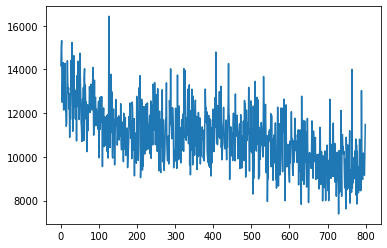

In [17]:
plt.plot(loss_list)
plt.show()

In [18]:
more_epochs = 22
for epoch in range(more_epochs):
    print(f'Now epoch {epoch+9} !')
    loss_list += train_de_grad(degrad_model, train_dataloader, measurement_process, lossfunction, optimizer, device)

Now epoch 9 !
Now epoch 10 !
Now epoch 11 !
Now epoch 12 !
Now epoch 13 !
Now epoch 14 !
Now epoch 15 !
Now epoch 16 !
Now epoch 17 !
Now epoch 18 !
Now epoch 19 !
Now epoch 20 !
Now epoch 21 !
Now epoch 22 !
Now epoch 23 !
Now epoch 24 !
Now epoch 25 !
Now epoch 26 !
Now epoch 27 !
Now epoch 28 !


KeyboardInterrupt: ignored

In [19]:
len(loss_list)

2700

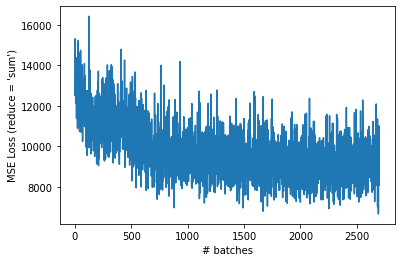

In [20]:
plt.plot(loss_list)
plt.xlabel("# batches")
plt.ylabel("MSE Loss (reduce = 'sum')")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'blurred image')

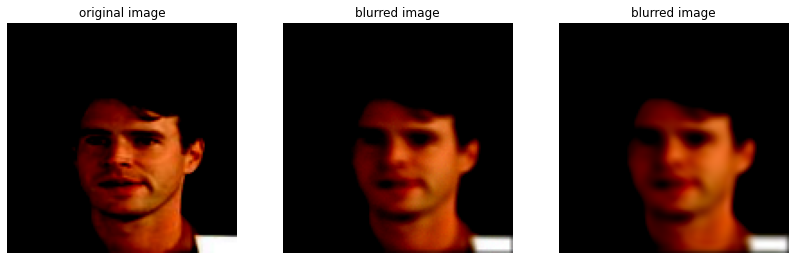

In [11]:
# Try to see some samples after 23 epochs
data_batch = iter(test_dataloader).next()
batch_d = measurement_process.forward(data_batch.to(device)) # measure
batch_reconstruct = degrad_model.forward(batch_d) # reconstruction
fig = plt.figure()
fig.set_size_inches(14, 10)
fig.add_subplot(1, 3, 1)
plt.imshow(data_batch[0,:,:,:].detach().to('cpu').numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title("original image")
fig.add_subplot(1, 3, 2)
plt.imshow(batch_d[0, :, :, :].detach().to('cpu').numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title("blurred image")
fig.add_subplot(1, 3, 3)
plt.imshow(batch_reconstruct[0, :, :, :].detach().to('cpu').numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title("blurred image")

In [12]:
# Evaluate PSNR using Gilton's metric
mse_loss = torch.nn.MSELoss()
degrad_mse = mse_loss(batch_reconstruct[0, :, :, :].detach().to('cpu'), data_batch[0, :, :, :]).item()
degrad_PSNR = -10 * np.log10(degrad_mse)
blur_mse = mse_loss(batch_d[0, :, :, :].detach().to('cpu'), data_batch[0, :, :, :]).item()
blur_PSNR = -10 * np.log10(blur_mse)
print(f"PSNR for reconstructed result is {degrad_PSNR:.4f}")
print(f"PSNR of the blurred image is {blur_PSNR:.4f}")

PSNR for reconstructed result is 20.7957
PSNR of the blurred image is 21.5572


In [13]:
# Evaluate SSIM using Gilton's metric
ssim_calculator = SSIM()
degrad_ssim = ssim_calculator.forward(torch.unsqueeze(batch_reconstruct[0, :, :, :].detach().to('cpu'), 0), torch.unsqueeze(data_batch[0, :, :, :], 0)).item()
blur_ssim = ssim_calculator.forward(torch.unsqueeze(batch_d[0, :, :, :].detach().to('cpu'), 0), torch.unsqueeze(data_batch[0, :, :, :], 0)).item()
print(f"SSIM for gradient descent result is {degrad_ssim:.4f}")
print(f"SSIM of the blurred image is {blur_ssim:.4f}")

SSIM for gradient descent result is 0.7918
SSIM of the blurred image is 0.8029


In [ ]:
more_epochs = 27
for epoch in range(more_epochs):
    print(f'Now epoch {epoch+24} !')
    loss_list += train_de_grad(degrad_model, train_dataloader, measurement_process, lossfunction, optimizer, device)

Now epoch 24 !
Now epoch 25 !
Now epoch 26 !
Now epoch 27 !
Now epoch 28 !
Now epoch 29 !
Now epoch 30 !
Now epoch 31 !
Now epoch 32 !
Now epoch 33 !
Now epoch 34 !
Now epoch 35 !
Now epoch 36 !
Now epoch 37 !
Now epoch 38 !
Now epoch 39 !
Now epoch 40 !
Now epoch 41 !
Now epoch 42 !
Now epoch 43 !
Now epoch 44 !
Now epoch 45 !
Now epoch 46 !
Now epoch 47 !
Now epoch 48 !
Now epoch 49 !
Now epoch 50 !


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'blurred image')

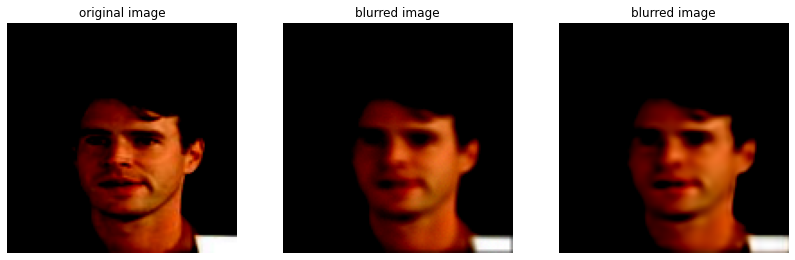

In [ ]:
# Try to see some samples after 50 epochs
data_batch = iter(test_dataloader).next()
batch_d = measurement_process.forward(data_batch.to(device)) # measure
batch_reconstruct = degrad_model.forward(batch_d) # reconstruction
fig = plt.figure()
fig.set_size_inches(14, 10)
fig.add_subplot(1, 3, 1)
plt.imshow(data_batch[0,:,:,:].detach().to('cpu').numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title("original image")
fig.add_subplot(1, 3, 2)
plt.imshow(batch_d[0, :, :, :].detach().to('cpu').numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title("blurred image")
fig.add_subplot(1, 3, 3)
plt.imshow(batch_reconstruct[0, :, :, :].detach().to('cpu').numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title("blurred image")

In [ ]:
# Evaluate PSNR using Gilton's metric
mse_loss = torch.nn.MSELoss()
degrad_mse = mse_loss(batch_reconstruct[0, :, :, :].detach().to('cpu'), data_batch[0, :, :, :]).item()
degrad_PSNR = -10 * np.log10(degrad_mse)
blur_mse = mse_loss(batch_d[0, :, :, :].detach().to('cpu'), data_batch[0, :, :, :]).item()
blur_PSNR = -10 * np.log10(blur_mse)
print(f"PSNR for reconstructed result is {degrad_PSNR:.4f}")
print(f"PSNR of the blurred image is {blur_PSNR:.4f}")

PSNR for reconstructed result is 25.6890
PSNR of the blurred image is 21.5696


In [ ]:
# Evaluate SSIM using Gilton's metric
ssim_calculator = SSIM()
degrad_ssim = ssim_calculator.forward(torch.unsqueeze(batch_reconstruct[0, :, :, :].detach().to('cpu'), 0), torch.unsqueeze(data_batch[0, :, :, :], 0)).item()
blur_ssim = ssim_calculator.forward(torch.unsqueeze(batch_d[0, :, :, :].detach().to('cpu'), 0), torch.unsqueeze(data_batch[0, :, :, :], 0)).item()
print(f"SSIM for gradient descent result is {degrad_ssim:.4f}")
print(f"SSIM of the blurred image is {blur_ssim:.4f}")

SSIM for gradient descent result is 0.8677
SSIM of the blurred image is 0.8032


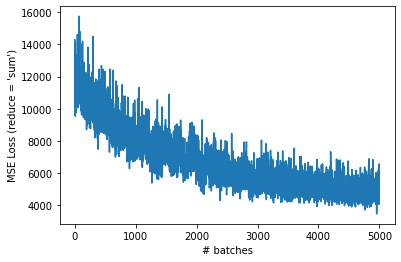

In [ ]:
plt.plot(loss_list)
plt.xlabel("# batches")
plt.ylabel("MSE Loss (reduce = 'sum')")
plt.show()

In [ ]:
more_epochs = 30
for epoch in range(more_epochs):
    print(f'Now epoch {epoch+51} !')
    loss_list += train_de_grad(degrad_model, train_dataloader, measurement_process, lossfunction, optimizer, device)

# DE-PROX

For DE-PROX, we use the exact same set-up as DE-GRAD, with the only difference in $T_\Theta (\cdot)$: 
$$ T_\Theta (x) = \text{Prox}_{\eta} \ (x - \eta \mathcal{A}^T(\mathcal{A} x -d)) = R_\Theta \ (x - \eta \mathcal{A}^T(\mathcal{A} x -d)) $$

In [ ]:
class DEPROX(torch.nn.Module):
    def __init__(self):
        super.__init__()
    
    pass